# **Project Description**

In this notebook there is an implementation of an **Algorithmic Trading** strategy that utilizes a **Deep Reinforcement Learning (DRL)** framework.

The core methodology employs an **LSTM-based Actor-Critic (A2C)** agent, which is trained to perform **dynamic portfolio optimization** on a basket of **Italian, German, and French equities**.

The agent learns an optimal trading policy over a training period (2019-2023) and is evaluated on a test set (2023-2025), aiming to maximize returns while managing risk.

The final output includes performance metrics (Cumulative Return, Sharpe Ratio, and Maximum Drawdown) compared against a simple Buy-and-Hold benchmark.

#Warning

This notebook is not a financial advisor.


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
from collections import deque

[*********************100%***********************]  15 of 15 completed


Data fetched and preprocessed.
Training data from 2019-01-02 00:00:00 to 2023-11-08 00:00:00
Testing data from 2023-11-09 00:00:00 to 2025-01-30 00:00:00
Actor-Critic models built successfully.


Model: "Policy"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ price_input         │ (None, 50, 75)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 50, 64)    │     35,840 │ price_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │     12,416 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weights_input       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 48)        │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ weights_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      3,136 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │      1,040 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,497 (205.07 KB)

 Trainable params: 52,497 (205.07 KB)

 Non-trainable params: 0 (0.00 B)

Episode 1/50 | Portfolio Value: 1.74 | Total Reward: 0.5541 | Actor Loss: -0.0498 | Critic Loss: 0.0126
Episode 2/50 | Portfolio Value: 1.75 | Total Reward: 0.5591 | Actor Loss: 0.2207 | Critic Loss: 0.0135
Episode 3/50 | Portfolio Value: 1.75 | Total Reward: 0.5624 | Actor Loss: 0.0542 | Critic Loss: 0.0066
Episode 4/50 | Portfolio Value: 1.76 | Total Reward: 0.5625 | Actor Loss: -0.1034 | Critic Loss: 0.0070
Episode 5/50 | Portfolio Value: 1.76 | Total Reward: 0.5638 | Actor Loss: -0.1228 | Critic Loss: 0.0072
Episode 6/50 | Portfolio Value: 1.76 | Total Reward: 0.5647 | Actor Loss: -0.0417 | Critic Loss: 0.0058
Episode 7/50 | Portfolio Value: 1.76 | Total Reward: 0.5647 | Actor Loss: 0.0379 | Critic Loss: 0.0058
Episode 8/50 | Portfolio Value: 1.76 | Total Reward: 0.5640 | Actor Loss: 0.0600 | Critic Loss: 0.0054
Episode 9/50 | Portfolio Value: 1.76 | Total Reward: 0.5631 | Actor Loss: 0.0334 | Critic Loss: 0.0043
Episode 10/50 | Portfolio Value: 1.75 | Total Reward: 0.5608 | Actor 

/tmp/ipython-input-3857031.py:291: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  price_close = data.stack(level=0)['Close'].unstack()



--- Performance on Test Set ---

A2C Agent Metrics:
- Cumulative Return: 41.16%
- Annualized Sharpe Ratio: 2.56
- Maximum Drawdown: -10.24%

Buy and Hold Benchmark Metrics:
- Cumulative Return: 56.02%
- Annualized Sharpe Ratio: 2.75
- Maximum Drawdown: -11.05%


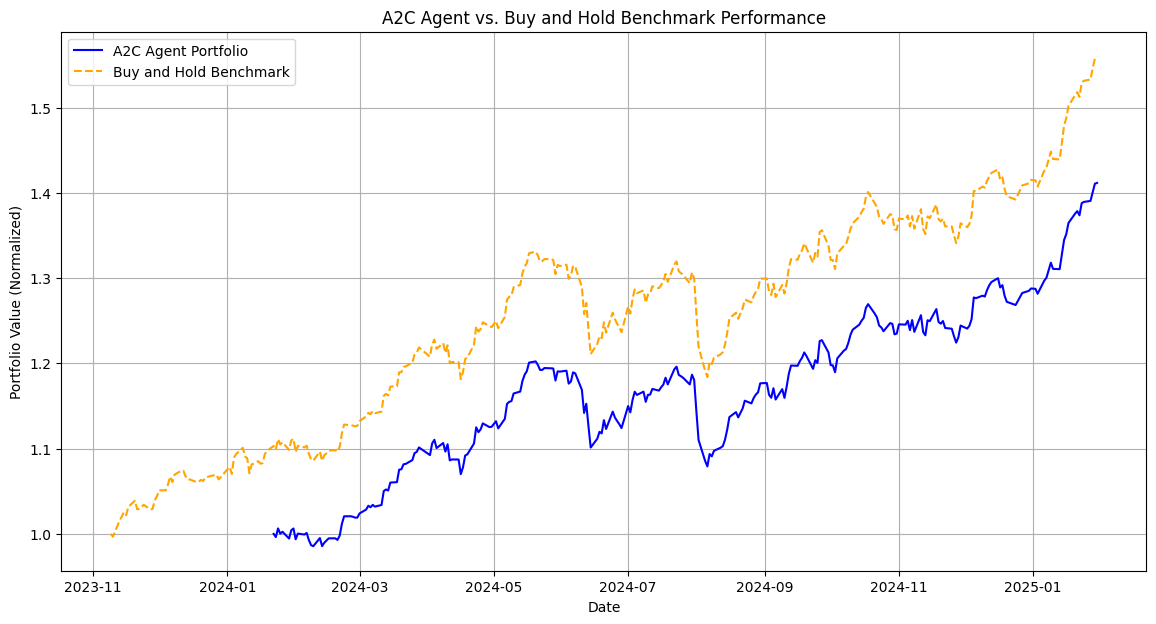

In [ ]:

TICKERS = [

    "AZM.MI", "BAMI.MI", "BGN.MI", "BMED.MI", "BPE.MI",

    "ALV.DE", "CBK.DE", "DBK.DE", "DB1.DE", "DTE.DE",

    "BNP.PA", "CS.PA", "GLE.PA", "ACA.PA", "CAP.PA"
]

ASSETS = ["CASH"] + TICKERS
NUM_ASSETS = len(ASSETS)
NUM_TICKERS = len(TICKERS)
NUM_FEATURES = 5

START_DATE = "2019-01-01"
END_DATE = "2025-01-31"


LOOKBACK_WINDOW_SIZE = 50
TRANSACTION_COST = 0.002



def get_data(tickers, start, end):

    data = yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=True)
    price_data = pd.DataFrame()
    for ticker in tickers:
        df_ticker = data[ticker].ffill().bfill()

        df_ticker = df_ticker[['Open', 'High', 'Low', 'Close', 'Volume']]
        df_ticker.columns = pd.MultiIndex.from_product([[ticker], df_ticker.columns])
        price_data = pd.concat([price_data, df_ticker], axis=1)
    print("Data fetched and preprocessed.")
    return price_data


price_data = get_data(TICKERS, START_DATE, END_DATE)
split_index = int(len(price_data) * 0.8)
train_data = price_data[:split_index]
test_data = price_data[split_index:]

print(f"Training data from {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data from {test_data.index.min()} to {test_data.index.max()}")



class PortfolioEnv:

    def __init__(self, data, lookback_window=50, transaction_cost=0.002):
        self.data = data
        self.lookback_window = lookback_window
        self.transaction_cost = transaction_cost
        self.dates = self.data.index[self.lookback_window:]
        self.current_step = 0
        self.prices = self.data

        self.norm_prices = self.prices / self.prices.iloc[0]


        self.weights = np.zeros(NUM_ASSETS)
        self.weights[0] = 1.0
        self.portfolio_value = 1.0
        self.history = []

    def _get_state(self):

        start = self.current_step
        end = start + self.lookback_window

        price_history = self.norm_prices.iloc[start:end].values.reshape(self.lookback_window, NUM_TICKERS * NUM_FEATURES)
        state = {
            "price_history": price_history,
            "weights": self.weights
        }
        return state

    def reset(self):

        self.current_step = 0
        self.weights = np.zeros(NUM_ASSETS)
        self.weights[0] = 1.0
        self.portfolio_value = 1.0
        self.history = []
        return self._get_state()

    def step(self, action_weights):


        new_weights = action_weights


        rebalance_cost = self.transaction_cost * np.sum(np.abs(new_weights - self.weights))


        current_prices = self.prices.iloc[self.current_step + self.lookback_window]
        prev_prices = self.prices.iloc[self.current_step + self.lookback_window - 1]

        current_close_prices = current_prices.loc[(slice(None), 'Close')].values
        prev_close_prices = prev_prices.loc[(slice(None), 'Close')].values

        price_relatives = np.ones(NUM_ASSETS)
        price_relatives[1:] = current_close_prices / prev_close_prices


        portfolio_return_before_cost = np.dot(self.weights, price_relatives)


        self.portfolio_value *= (portfolio_return_before_cost * (1 - rebalance_cost))


        self.weights = new_weights


        reward = np.log(portfolio_return_before_cost * (1 - rebalance_cost))


        self.current_step += 1
        done = self.current_step >= len(self.dates)

        next_state = self._get_state() if not done else None


        self.history.append(self.portfolio_value)

        return next_state, reward, done, {"portfolio_value": self.portfolio_value}



class ActorCriticAgent:
    def __init__(self, lookback_window, num_assets, action_space_size):
        self.lookback_window = lookback_window
        self.num_assets = num_assets
        self.action_space_size = action_space_size

        self.actor_lr = 0.0001
        self.critic_lr = 0.0005
        self.gamma = 0.99

        self.actor, self.critic, self.policy = self._build_models()
        self.actor_optimizer = Adam(learning_rate=self.actor_lr)
        self.critic_optimizer = Adam(learning_rate=self.critic_lr)

    def _build_models(self):

        price_input = Input(shape=(self.lookback_window, NUM_TICKERS * NUM_FEATURES), name='price_input')
        weights_input = Input(shape=(self.num_assets,), name='weights_input')


        lstm_out = LSTM(64, return_sequences=True)(price_input)
        lstm_out = LSTM(32)(lstm_out)
        concat = Concatenate()([lstm_out, weights_input])
        shared_dense = Dense(64, activation='relu')(concat)


        actor_output = Dense(self.action_space_size, activation='softmax')(shared_dense)


        critic_output = Dense(1, activation='linear')(shared_dense)


        actor = Model(inputs=[price_input, weights_input], outputs=actor_output, name="Actor")
        critic = Model(inputs=[price_input, weights_input], outputs=critic_output, name="Critic")


        policy = Model(inputs=[price_input, weights_input], outputs=[actor_output, critic_output], name="Policy")

        return actor, critic, policy

    def act(self, state):

        price_hist = state['price_history'][np.newaxis, ...].astype('float32')
        weights = state['weights'][np.newaxis, ...].astype('float32')
        action_probs, _ = self.policy.predict([price_hist, weights], verbose=0)
        return action_probs[0]

    def train(self, states, actions, rewards, dones):

        discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
        running_add = 0
        for t in reversed(range(len(rewards))):
            running_add = rewards[t] + self.gamma * running_add * (1-dones[t])
            discounted_rewards[t] = running_add


        state_price_hists = np.array([s['price_history'] for s in states]).astype('float32')
        state_weights = np.array([s['weights'] for s in states]).astype('float32')
        actions = np.array(actions).astype('float32')

        with tf.GradientTape() as tape_actor, tf.GradientTape() as tape_critic:

            action_probs, critic_values = self.policy([state_price_hists, state_weights], training=True)
            critic_values = tf.squeeze(critic_values)


            advantages = discounted_rewards - critic_values


            cce = tf.keras.losses.CategoricalCrossentropy()
            actor_loss = cce(actions, action_probs, sample_weight=tf.stop_gradient(advantages))


            mse = tf.keras.losses.MeanSquaredError()
            critic_loss = mse(discounted_rewards, critic_values)


        actor_grads = tape_actor.gradient(actor_loss, self.actor.trainable_variables)
        critic_grads = tape_critic.gradient(critic_loss, self.critic.trainable_variables)

        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

        return actor_loss, critic_loss




env = PortfolioEnv(train_data, LOOKBACK_WINDOW_SIZE, TRANSACTION_COST)
agent = ActorCriticAgent(LOOKBACK_WINDOW_SIZE, NUM_ASSETS, NUM_ASSETS)
episodes = 50

print("Actor-Critic models built successfully.")
agent.policy.summary()

total_rewards_history = []

for e in range(episodes):
    state = env.reset()
    done = False

    episode_states, episode_actions, episode_rewards, episode_dones = [], [], [], []

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)

        episode_states.append(state)
        episode_actions.append(action)
        episode_rewards.append(reward)
        episode_dones.append(done)

        state = next_state


    actor_loss, critic_loss = agent.train(episode_states, episode_actions, episode_rewards, episode_dones)

    total_reward = np.sum(episode_rewards)
    total_rewards_history.append(total_reward)

    print(f"Episode {e+1}/{episodes} | Portfolio Value: {info['portfolio_value']:.2f} | "
          f"Total Reward: {total_reward:.4f} | "
          f"Actor Loss: {actor_loss:.4f} | Critic Loss: {critic_loss:.4f}")



def backtest(env, agent):

    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        next_state, _, done, _ = env.step(action)
        state = next_state

    start_index = env.lookback_window -1
    end_index = start_index + len(env.history)
    portfolio_curve = pd.Series([1.0] + env.history, index=env.data.index[start_index:end_index+1])
    return portfolio_curve



test_env = PortfolioEnv(test_data, LOOKBACK_WINDOW_SIZE, TRANSACTION_COST)
a2c_portfolio_values = backtest(test_env, agent)


def buy_and_hold_benchmark(data):

    price_close = data.stack(level=0)['Close'].unstack()
    returns = price_close.pct_change().dropna()
    num_stocks = len(TICKERS)
    weights = np.array([1/num_stocks] * num_stocks)
    portfolio_returns = returns.dot(weights)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    initial_investment = pd.Series([1.0], index=[returns.index[0] - pd.Timedelta(days=1)])
    return pd.concat([initial_investment, cumulative_returns])

bah_portfolio_values = buy_and_hold_benchmark(test_data)



def calculate_metrics(portfolio_values):

    cumulative_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
    daily_returns = portfolio_values.pct_change().dropna()
    if daily_returns.std() == 0:
        sharpe_ratio = 0.0
    else:
        sharpe_ratio = np.sqrt(252) * (daily_returns.mean() / daily_returns.std())
    running_max = portfolio_values.expanding().max()
    drawdown = (portfolio_values - running_max) / running_max
    max_drawdown = drawdown.min()
    return {
        "Cumulative Return": f"{cumulative_return:.2%}",
        "Annualized Sharpe Ratio": f"{sharpe_ratio:.2f}",
        "Maximum Drawdown": f"{max_drawdown:.2%}"
    }

a2c_metrics = calculate_metrics(a2c_portfolio_values)
bah_metrics = calculate_metrics(bah_portfolio_values)

print("\n--- Performance on Test Set ---")
print("\nA2C Agent Metrics:")
for metric, value in a2c_metrics.items():
    print(f"- {metric}: {value}")

print("\nBuy and Hold Benchmark Metrics:")
for metric, value in bah_metrics.items():
    print(f"- {metric}: {value}")


plt.figure(figsize=(14, 7))
plt.plot(a2c_portfolio_values.index, a2c_portfolio_values.values, label='A2C Agent Portfolio', color='blue')
plt.plot(bah_portfolio_values.index, bah_portfolio_values.values, label='Buy and Hold Benchmark', color='orange', linestyle='--')
plt.title('A2C Agent vs. Buy and Hold Benchmark Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Normalized)')
plt.legend()
plt.grid(True)
plt.show()